In [105]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report
import matplotlib.pyplot as plt


In [4]:
#already one hot encoded dataset
data = pd.read_csv("Final_data.csv")
data = data.drop(columns=['Unnamed: 0'])
data.head()

,Total_types,total_Cuisines,approx_cost(for two people),target,online_order_Yes,book_table_Yes,location_Banashankari,location_Banaswadi,location_Bannerghatta Road,location_Basavanagudi,...,listed_in(city)_Lavelle Road,listed_in(city)_MG Road,listed_in(city)_Malleshwaram,listed_in(city)_Marathahalli,listed_in(city)_New BEL Road,listed_in(city)_Old Airport Road,listed_in(city)_Rajajinagar,listed_in(city)_Residency Road,listed_in(city)_Sarjapur Road,listed_in(city)_Whitefield
0,1,3,800.0,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,800.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,800.0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,2,300.0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,2,600.0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
X = data.drop(columns=['target'])
y = data['target']

In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [15]:
X_train.shape

torch.Size([33016, 96])

In [17]:
y_train.shape

torch.Size([33016])

In [21]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


In [13]:
#dataloader divide the rows by batch size so each batch size has 100 rows
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False)

## Simple Neural Network

In [33]:
class SimpleNeuralNetwork(nn.Module):
    #instantiate the model with 96 dimesional input
    def __init__(self, input_dim=96):
        super().__init__()
        #nn.linear is linear transformation between two dimesnions
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 32)
        #output layer is 1 dimensional as sigmoid will be used for classification
        self.output = nn.Linear(32, 1)
    
    #defining forward propagation
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.output(x))
        return x


## Simple Neural Network clearly overfits after some epochs with testing losses rising to previous high values and training loss still decreasing

In [64]:
#create instance of model and initialise weight
model = SimpleNeuralNetwork()
#loss function
criterion = nn.BCELoss()
#Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
#for every epoch
for epoch in range(epochs):
    #put model in training mode
    model.train()
    #set train loss to zero
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        #forward propagate with minibatch of size 100X96
        outputs = model.forward(X_batch)
        #calculate the BCE loss for entire minibatch
        #make y_batch which is a 1d tensor to size (batchsize,1)
        #loss is always averaged to give loss per data row in a minibatch
        loss = criterion(outputs, y_batch.unsqueeze(dim=1))
        
        # Update parameters
        #clear out all calculated gradeints in the previos batch
        optimizer.zero_grad()
        #calculate gradients by back propagation
        loss.backward()
        #update paramters keeping in mind the momentum and moments
        optimizer.step()
        
        #since loss is averaged for each minibatch, we multiply by size of batch to scale it back to original loss
        #This is necessary as last minibatch won't be of same size
        #X_batch.size(0) returns a python float 
        #.item is used so that we get python float only
        train_loss += loss.item() * X_batch.size(0)
    
    
    #total avg loss after each epoch
    train_loss /= len(train_loader.dataset)
    
    
    
    # Evaluate on test data
    #activate evaluation mode of model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    #donot calculate and change any gradient
    with torch.no_grad():
        #load the test dataset
        for X_batch, y_batch in test_loader:
            #forward propagate with X_train, output size is 100X1
            outputs = model.forward(X_batch)
            #calculate average BCE
            loss = criterion(outputs, y_batch.unsqueeze(dim = 1))
            #append the test loss 
            test_loss += loss.item() * X_batch.size(0)
            #calulate how many prediction are one, .float() convert true into 1 and false into zero (it is a pytorch inbuilt)
            predicted = (outputs.squeeze() > 0.5).float()
            #total batch size
            total += y_batch.size(0)
            #correct prediction out of total
            correct += (predicted == y_batch).sum().item()
    
    #average test loss
    test_loss /= len(test_loader.dataset)
    #accuracy after one epoch
    accuracy = correct / total
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/100], Train Loss: 0.5548, Test Loss: 0.5310, Accuracy: 0.7300
Epoch [2/100], Train Loss: 0.5189, Test Loss: 0.5253, Accuracy: 0.7329
Epoch [3/100], Train Loss: 0.5086, Test Loss: 0.5186, Accuracy: 0.7348
Epoch [4/100], Train Loss: 0.4980, Test Loss: 0.5121, Accuracy: 0.7366
Epoch [5/100], Train Loss: 0.4900, Test Loss: 0.5069, Accuracy: 0.7396
Epoch [6/100], Train Loss: 0.4810, Test Loss: 0.4972, Accuracy: 0.7450
Epoch [7/100], Train Loss: 0.4736, Test Loss: 0.4963, Accuracy: 0.7484
Epoch [8/100], Train Loss: 0.4669, Test Loss: 0.4930, Accuracy: 0.7498
Epoch [9/100], Train Loss: 0.4619, Test Loss: 0.4871, Accuracy: 0.7522
Epoch [10/100], Train Loss: 0.4556, Test Loss: 0.4875, Accuracy: 0.7518
Epoch [11/100], Train Loss: 0.4503, Test Loss: 0.4835, Accuracy: 0.7559
Epoch [12/100], Train Loss: 0.4463, Test Loss: 0.4802, Accuracy: 0.7572
Epoch [13/100], Train Loss: 0.4415, Test Loss: 0.4760, Accuracy: 0.7584
Epoch [14/100], Train Loss: 0.4364, Test Loss: 0.4786, Accuracy: 0.7559
E

## Scheduler Stagnates the learning too early

In [65]:
from torch.optim.lr_scheduler import StepLR

model = SimpleNeuralNetwork()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#reduce learning rate to 1/10 after 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)

# Training loop
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)
    
    train_loss /= len(train_loader.dataset)
    
    # Evaluate on test data
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            loss = criterion(outputs.squeeze(), y_batch)
            test_loss += loss.item() * X_batch.size(0)
            predicted = (outputs.squeeze() > 0.5).float()
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = correct / total
    
    scheduler.step()
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')


Epoch [1/100], Train Loss: 0.5559, Test Loss: 0.5329, Accuracy: 0.7285
Epoch [2/100], Train Loss: 0.5200, Test Loss: 0.5273, Accuracy: 0.7343
Epoch [3/100], Train Loss: 0.5103, Test Loss: 0.5192, Accuracy: 0.7359
Epoch [4/100], Train Loss: 0.5012, Test Loss: 0.5131, Accuracy: 0.7393
Epoch [5/100], Train Loss: 0.4932, Test Loss: 0.5075, Accuracy: 0.7393
Epoch [6/100], Train Loss: 0.4849, Test Loss: 0.5086, Accuracy: 0.7417
Epoch [7/100], Train Loss: 0.4782, Test Loss: 0.4977, Accuracy: 0.7478
Epoch [8/100], Train Loss: 0.4717, Test Loss: 0.4998, Accuracy: 0.7482
Epoch [9/100], Train Loss: 0.4665, Test Loss: 0.4970, Accuracy: 0.7514
Epoch [10/100], Train Loss: 0.4604, Test Loss: 0.4892, Accuracy: 0.7551
Epoch [11/100], Train Loss: 0.4544, Test Loss: 0.4872, Accuracy: 0.7555
Epoch [12/100], Train Loss: 0.4505, Test Loss: 0.4855, Accuracy: 0.7554
Epoch [13/100], Train Loss: 0.4456, Test Loss: 0.4868, Accuracy: 0.7588
Epoch [14/100], Train Loss: 0.4411, Test Loss: 0.4808, Accuracy: 0.7611
E

## We introduce Regularization for better Learning

In [40]:
class DropoutNeuralNetwork(nn.Module):
    def __init__(self, input_dim=96):
        super().__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        #dropout layer with 50 percent probability
        self.dropout1 = nn.Dropout(0.5)
        self.layer2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout1(x)
        x = torch.relu(self.layer2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.output(x))
        return x

In [69]:
model = DropoutNeuralNetwork()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


epochs = 100
#for every epoch
for epoch in range(epochs):
    #put model in training mode
    model.train()
    #set train loss to zero
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        #forward propagate with minibatch of size 100X96
        outputs = model.forward(X_batch)
        #calculate the BCE loss for entire minibatch
        #make y_batch which is a 1d tensor to size (batchsize,1)
        #loss is always averaged to give loss per data row in a minibatch
        loss = criterion(outputs, y_batch.unsqueeze(dim=1))
        
        # Update parameters
        #clear out all calculated gradeints in the previos batch
        optimizer.zero_grad()
        #calculate gradients by back propagation
        loss.backward()
        #update paramters keeping in mind the momentum and moments
        optimizer.step()
        
        #since loss is averaged for each minibatch, we multiply by size of batch to scale it back to original loss
        #This is necessary as last minibatch won't be of same size
        #X_batch.size(0) returns a python float 
        #.item is used so that we get python float only
        train_loss += loss.item() * X_batch.size(0)
    
    
    #total avg loss after each epoch
    train_loss /= len(train_loader.dataset)
    
    
    
    # Evaluate on test data
    #activate evaluation mode of model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    #donot calculate and change any gradient
    with torch.no_grad():
        #load the test dataset
        for X_batch, y_batch in test_loader:
            #forward propagate with X_train, output size is 100X1
            outputs = model.forward(X_batch)
            #calculate average BCE
            loss = criterion(outputs, y_batch.unsqueeze(dim = 1))
            #append the test loss 
            test_loss += loss.item() * X_batch.size(0)
            #calulate how many prediction are one, .float() convert true into 1 and false into zero (it is a pytorch inbuilt)
            predicted = (outputs.squeeze() > 0.5).float()
            #total batch size
            total += y_batch.size(0)
            #correct prediction out of total
            correct += (predicted == y_batch).sum().item()
    
    #average test loss
    test_loss /= len(test_loader.dataset)
    #accuracy after one epoch
    accuracy = correct / total
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.4f}')

Epoch [1/100], Train Loss: 0.5938, Test Loss: 0.5407, Accuracy: 0.7262
Epoch [2/100], Train Loss: 0.5487, Test Loss: 0.5331, Accuracy: 0.7263
Epoch [3/100], Train Loss: 0.5404, Test Loss: 0.5300, Accuracy: 0.7295
Epoch [4/100], Train Loss: 0.5348, Test Loss: 0.5270, Accuracy: 0.7290
Epoch [5/100], Train Loss: 0.5316, Test Loss: 0.5241, Accuracy: 0.7320
Epoch [6/100], Train Loss: 0.5303, Test Loss: 0.5222, Accuracy: 0.7352
Epoch [7/100], Train Loss: 0.5261, Test Loss: 0.5177, Accuracy: 0.7364
Epoch [8/100], Train Loss: 0.5242, Test Loss: 0.5167, Accuracy: 0.7364
Epoch [9/100], Train Loss: 0.5207, Test Loss: 0.5140, Accuracy: 0.7415
Epoch [10/100], Train Loss: 0.5208, Test Loss: 0.5117, Accuracy: 0.7377
Epoch [11/100], Train Loss: 0.5177, Test Loss: 0.5102, Accuracy: 0.7403
Epoch [12/100], Train Loss: 0.5174, Test Loss: 0.5099, Accuracy: 0.7398
Epoch [13/100], Train Loss: 0.5151, Test Loss: 0.5090, Accuracy: 0.7432
Epoch [14/100], Train Loss: 0.5118, Test Loss: 0.5063, Accuracy: 0.7417
E

## Early Stopping

In [75]:
model = DropoutNeuralNetwork()
# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Early stopping parameters
#initilialize best loss as infinity
best_loss = float('inf')
#10 is patience parameter
patience = 10
epochs_no_improve = 0
epochs = 200

for epoch in range(epochs):
    #put model in training mode
    model.train()
    #set train loss to zero
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        #forward propagate with minibatch of size 100X96
        outputs = model.forward(X_batch)
        #calculate the BCE loss for entire minibatch
        #make y_batch which is a 1d tensor to size (batchsize,1)
        #loss is always averaged to give loss per data row in a minibatch
        loss = criterion(outputs, y_batch.unsqueeze(dim=1))
        
        # Update parameters
        #clear out all calculated gradeints in the previos batch
        optimizer.zero_grad()
        #calculate gradients by back propagation
        loss.backward()
        #update paramters keeping in mind the momentum and moments
        optimizer.step()
        
        #since loss is averaged for each minibatch, we multiply by size of batch to scale it back to original loss
        #This is necessary as last minibatch won't be of same size
        #X_batch.size(0) returns a python float 
        #.item is used so that we get python float only
        train_loss += loss.item() * X_batch.size(0)
    
    
    #total avg loss after each epoch
    train_loss /= len(train_loader.dataset)
    
    
    
    # Evaluate on test data
    #activate evaluation mode of model
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    #donot calculate and change any gradient
    with torch.no_grad():
        #load the test dataset
        for X_batch, y_batch in test_loader:
            #forward propagate with X_train, output size is 100X1
            outputs = model.forward(X_batch)
            #calculate average BCE
            loss = criterion(outputs, y_batch.unsqueeze(dim = 1))
            #append the test loss 
            test_loss += loss.item() * X_batch.size(0)
            #calulate how many prediction are one, .float() convert true into 1 and false into zero (it is a pytorch inbuilt)
            predicted = (outputs.squeeze() > 0.5).float()
            #total batch size
            total += y_batch.size(0)
            #correct prediction out of total
            correct += (predicted == y_batch).sum().item()
    
    #average test loss
    total_test_loss = test_loss/len(test_loader.dataset)
    #accuracy after one epoch
    accuracy = correct / total
    
    print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Test Loss: {total_test_loss:.4f}, Accuracy: {accuracy:.4f}')

    if total_test_loss < best_loss:
        best_loss = total_test_loss
        torch.save(model.state_dict(), 'best_model.pth')
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print("Early stopping triggered")
        break


Epoch [1/200], Train Loss: 0.5976, Test Loss: 0.5407, Accuracy: 0.7234
Epoch [2/200], Train Loss: 0.5478, Test Loss: 0.5336, Accuracy: 0.7282
Epoch [3/200], Train Loss: 0.5401, Test Loss: 0.5299, Accuracy: 0.7320
Epoch [4/200], Train Loss: 0.5353, Test Loss: 0.5277, Accuracy: 0.7342
Epoch [5/200], Train Loss: 0.5293, Test Loss: 0.5242, Accuracy: 0.7341
Epoch [6/200], Train Loss: 0.5264, Test Loss: 0.5224, Accuracy: 0.7351
Epoch [7/200], Train Loss: 0.5255, Test Loss: 0.5200, Accuracy: 0.7364
Epoch [8/200], Train Loss: 0.5231, Test Loss: 0.5183, Accuracy: 0.7381
Epoch [9/200], Train Loss: 0.5213, Test Loss: 0.5160, Accuracy: 0.7368
Epoch [10/200], Train Loss: 0.5182, Test Loss: 0.5126, Accuracy: 0.7383
Epoch [11/200], Train Loss: 0.5167, Test Loss: 0.5124, Accuracy: 0.7382
Epoch [12/200], Train Loss: 0.5144, Test Loss: 0.5098, Accuracy: 0.7396
Epoch [13/200], Train Loss: 0.5141, Test Loss: 0.5075, Accuracy: 0.7396
Epoch [14/200], Train Loss: 0.5112, Test Loss: 0.5055, Accuracy: 0.7405
E

Epoch [115/200], Train Loss: 0.4651, Test Loss: 0.4599, Accuracy: 0.7611
Epoch [116/200], Train Loss: 0.4630, Test Loss: 0.4587, Accuracy: 0.7638
Epoch [117/200], Train Loss: 0.4634, Test Loss: 0.4595, Accuracy: 0.7638
Epoch [118/200], Train Loss: 0.4627, Test Loss: 0.4586, Accuracy: 0.7631
Epoch [119/200], Train Loss: 0.4602, Test Loss: 0.4588, Accuracy: 0.7622
Epoch [120/200], Train Loss: 0.4640, Test Loss: 0.4624, Accuracy: 0.7610
Epoch [121/200], Train Loss: 0.4621, Test Loss: 0.4602, Accuracy: 0.7610
Epoch [122/200], Train Loss: 0.4635, Test Loss: 0.4608, Accuracy: 0.7617
Epoch [123/200], Train Loss: 0.4623, Test Loss: 0.4592, Accuracy: 0.7662
Epoch [124/200], Train Loss: 0.4604, Test Loss: 0.4590, Accuracy: 0.7637
Epoch [125/200], Train Loss: 0.4602, Test Loss: 0.4587, Accuracy: 0.7615
Epoch [126/200], Train Loss: 0.4619, Test Loss: 0.4582, Accuracy: 0.7627
Epoch [127/200], Train Loss: 0.4621, Test Loss: 0.4580, Accuracy: 0.7647
Epoch [128/200], Train Loss: 0.4625, Test Loss: 0.4

In [137]:
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model.forward(X_batch)
        predicted = (outputs.squeeze() > 0.5).float()
        #.tolist make tensor object as python list
        #.extend append the list with the elements of teh list
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())

## Turns out by default DNN model is very conservative with too many False Negatives

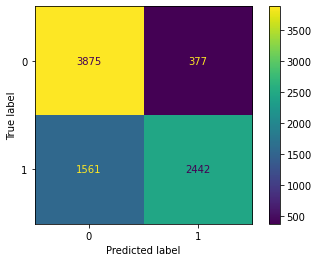

In [138]:
cm= confusion_matrix(y_true,y_pred)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmp.plot()

In [139]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

         0.0       0.71      0.91      0.80      4252
         1.0       0.87      0.61      0.72      4003

    accuracy                           0.77      8255
   macro avg       0.79      0.76      0.76      8255
weighted avg       0.79      0.77      0.76      8255



In [122]:
model.load_state_dict(torch.load('best_model.pth'))

# Evaluate on test data
model.eval()
y_true = []
y_probs = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        probs = outputs.squeeze()
        y_true.extend(y_batch.tolist())
        #instead of predictions append probabilities
        y_probs.extend(probs.tolist())

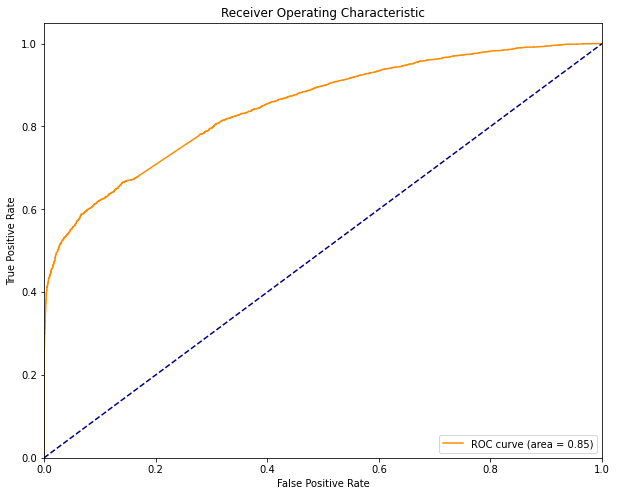

In [140]:
from sklearn.metrics import roc_curve, roc_auc_score

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy',  linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [141]:
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = roc_auc_score(y_true, y_probs)

# Calculate the distance to the point (0,1)
distances = np.sqrt((fpr - 0)**2 + (tpr - 1)**2)

# Find the index of the minimum distance
min_distance_index = np.argmin(distances)

# Best threshold
best_threshold = thresholds[min_distance_index]

print(f'Best Threshold: {best_threshold}')


Best Threshold: 0.4350343346595764


              precision    recall  f1-score   support

         0.0       0.73      0.84      0.78      4252
         1.0       0.80      0.67      0.73      4003

    accuracy                           0.76      8255
   macro avg       0.77      0.76      0.76      8255
weighted avg       0.77      0.76      0.76      8255



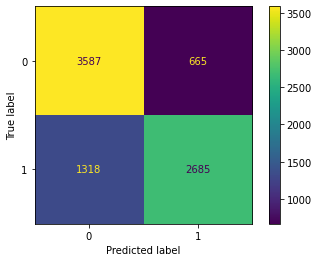

In [149]:
#with Changed threshold
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model.forward(X_batch)
        predicted = (outputs.squeeze() > 0.44).float()
        #.tolist make tensor object as python list
        #.extend append the list with the elements of teh list
        y_true.extend(y_batch.tolist())
        y_pred.extend(predicted.tolist())
        
        
print(classification_report(y_true, y_pred))        
cm= confusion_matrix(y_true,y_pred)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm)
cmp.plot()        